In [1]:
import numpy as np
import random as rm
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from scipy.stats import bernoulli, binom
from scipy import integrate

In [2]:
# build the target distribution
mu1, sigma1 = 0, 0.5
mu2, sigma2 = 17.5, 1
# N = 500

# x1 = np.random.normal(mu1, sigma1, N)
# x2 = np.random.normal(mu2, sigma2, N)

# f_pi = (0.4*x1 + 0.6*x2)

## Method 1

In [5]:
# calculate constant c
f_pi = lambda x: 0.4*(1/np.sqrt(2*math.pi*sigma1))*np.exp((-1/2)*((x-mu1)**2/sigma1)) + 0.6*(1/np.sqrt(2*math.pi*sigma2))*np.exp((-1/2)*((x-mu2)**2/sigma2))
pdf_eta = lambda x: np.power(0.4*(1/np.sqrt(2*math.pi*sigma1))*np.exp((-1/2)*((x-mu1)**2/sigma1)) + 0.6*(1/np.sqrt(2*math.pi*sigma2))*np.exp((-1/2)*((x-mu2)**2/sigma2)),0.75)
c = integrate.quad(pdf_eta, -inf, inf)
c = c[0]
print(f_pi(1))
print(c)

0.08302149948411895
1.6606303582223592


In [6]:
def pdf_eta(x):
    output = (f_pi(x))**0.75
    return(output)


In [7]:
# define eta
def f_eta(x):
    return(pdf_eta(x)/c)

#pdf_eta = lambda x: np.power(0.4*(1/np.sqrt(2*math.pi*sigma1))*np.exp((-1/2)*((x-mu1)**2/sigma1)) + 0.6*(1/np.sqrt(2*math.pi*sigma2))*np.exp((-1/2)*((x-mu2)**2/sigma2)),0.75)


In [8]:
# define g
def g(x):
    return(f_pi(x)/f_eta(x))

In [9]:
# P
def p_kernel(y0,sigma,n):
    count = 0
    Yn = y0
    estimator = [y0]
    while count<n:
        y = np.random.normal(Yn,sigma)
        u = np.random.uniform(0,1)
        alpha = min((pdf_eta(y)/pdf_eta(Yn)),1)
        if u <= alpha:
            estimator.append(y)
            Yn = y
            count +=1
    return estimator

In [10]:
# K
def k_kernel(x0,sigma):
    count = 0
    Xn = x0
    estimator = [x0]
    while count<1:
        y = np.random.normal(Xn,sigma)
        u = np.random.uniform(0,1)
        alpha = min((pdf_eta(y)/pdf_eta(Xn)),1)
        if u <= alpha:
            estimator.append(y)
            Xn = y
            count +=1
    return estimator[-1]

In [11]:
def S_y_new(n, sigma, y0):
    y = [y0]
    sumn = 0
    for i in range(n+1):
        y.append(p_kernel(y0,sigma,n))
    for k in y:
        sumn += g(k)
    return sumn

def sum_g_update(sum_old, yn):
    sum_new = sum_old + g(yn)
    return(sum_new)

def prob_list_new(y, sum_new):
    prob_list = []
    for i in y:
        prob_list.append(g(i)/sum_new)
    return prob_list

def bernoulli_list(epsilon, n):
    b_list = bernoulli(epsilon).rvs(n)
    return b_list

In [12]:
def prob_list(y):
    prob_list = []
    sum = 0
    for i in y:
        sum += g(i)
    for i in y:
        prob_list.append(g(i)/sum)
    return prob_list

def x_sample(x0, epsilon, y, n, sigma):
    X_list = [x0]
    bernoullis = bernoulli_list(epsilon, n)
    for k in range(1,n): # +1?
        i = bernoullis[k]
        if i == 0:
            X_list.append(k_kernel(x0, sigma))
        if i == 1:
            X_list.append(np.random.choice(y[:k], p = prob_list(y[:k])))
        x0 = X_list[-1]
    return X_list


In [13]:
# define epsilon
epsilon1 = 0.05
epsilon2 = 0.25
epsilon3 = 0.5
epsilon4 = 0.75
epsilon5 = 0.95

In [14]:
# expectation
def E_x(X_list):
    sum = 0
    for i in X_list:
        sum += i
    mean = sum/len(X_list)
    return mean

In [15]:
def x_sample_new(x0, epsilon, y0, n, sigma):
    X_list = [x0]
    Y_list = [y0]
    sum_gs = g(y0)
    Y_list = p_kernel(y0,sigma,n)
    for k in range(1, n):
        #YnPlusOne = p_kernel(Y_list[-1], sigma, 1)
        #print(YnPlusOne)
        #Y_list.append(YnPlusOne)
        sum_gs = sum_g_update(sum_gs, Y_list[k])
        #print(sum_gs)
        #print(Y_list[:k+1])
        prob_list_Ys = prob_list_new(Y_list[:k+1], sum_gs)
        bernoullis = bernoulli_list(epsilon, 1)
        i = bernoullis
        if i == 0:
            X_list.append(k_kernel(x0, sigma))
        if i == 1:
            X_list.append(np.random.choice(Y_list[:k+1], p = prob_list_Ys))
        x0 = X_list[-1]
        
    #x_bar = np.mean(X_list)*(1- 1/(n+1)) + 1/(n+1) * X_list[-1]
    #return x_bar
    return [X_list, Y_list]

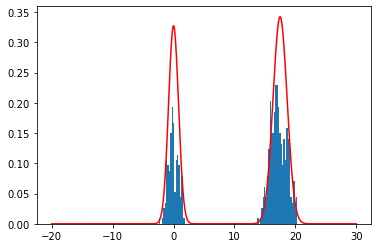

In [31]:
plt.hist(y, density = True, bins = 100)
t = np.linspace(-20,30,1000)
vals = pdf_eta(t)
plt.plot(t,vals, 'r')

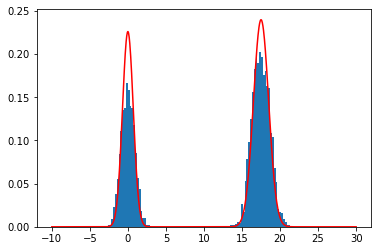

In [34]:
x0 = 10
y0 = 15
n = 5000
y = p_kernel(y0, 10, n)
x_list = x_sample(x0, epsilon1, y, n, 2)
#print(E_x(x_list))

plt.hist(x_list, bins = 100, density = True)
t = np.linspace(-10,30,1000)
vals = f_pi(t)
plt.plot(t,vals, 'r')

In [24]:
x0 = 10
y0 = 15
n = 3
y = p_kernel(y0, 10, n)
mean = x_sample_new(x0, epsilon2, y0, n, 2)
print(mean)

[[10, 12.36448164793569, 12.43626625390507], [15, 16.150932830502597, 16.580549369733607, 16.454103129537042]]


(array([103.,  42.,   0.,   0.,   0.,   2.,   1.,  71., 214.,  67.]),
 array([-1.77835763,  0.50136483,  2.78108729,  5.06080975,  7.34053221,
         9.62025467, 11.89997713, 14.17969959, 16.45942205, 18.7391445 ,
        21.01886696]),
 <BarContainer object of 10 artists>)

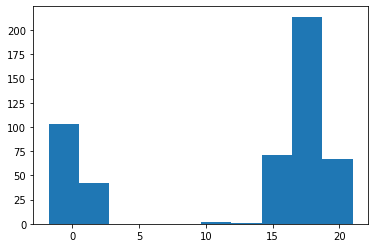

In [32]:
y = p_kernel(15, 10, 500)
mean = x_sample_new(x0, epsilon1, y0, n, 4)
plt.hist(mean[0])

(array([ 6.,  6.,  0.,  0.,  0.,  0.,  0.,  2., 20., 17.]),
 array([-1.98970637,  0.16823389,  2.32617414,  4.4841144 ,  6.64205466,
         8.79999492, 10.95793518, 13.11587544, 15.27381569, 17.43175595,
        19.58969621]),
 <BarContainer object of 10 artists>)

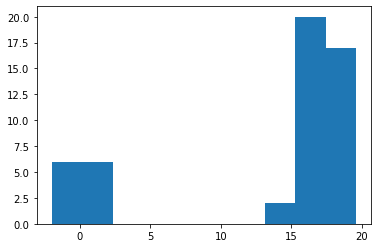

In [33]:
ytest = p_kernel(15, 10, 50)
#print(ytest)
plt.hist(ytest)